# Bias Frame and Dark Frame

A bias frame is a very short exposure taken with the shutter closed (typically the shortest possible exposure time for the camera).
It measures the bias noise: A fixed electronic noise added by the camera during readout.

If bias frames are used, the dark frame may be adjusted as: 

$$\text{True Dark Frame} = \text{Dark Frame} - \text{Bias}$$

A dark frame is an exposure taken with the same duration, temperature, and ISO/gain settings as the object frame but with the camera shutter closed. It measures:

- Dark current noise: Thermal electrons accumulating during the exposure.
- Bias noise: The camera's electronic readout noise.

The dark frame is subtracted from the object frame to remove dark current and bias noise. IF THE OBJECT FRAME AND THE DARK FRAME HAVE THE SAME INTEGRATION TIME:

$$\text{Calibrated Frame} = \text{Object Frame} - \text{Dark Frame}$$

Otherwise:

$$\text{Calibrated Frame} = \text{Object Frame} - (\text{Dark Frame}-\text{Bias})\tfrac{\Delta t_\text{obj}}{\Delta t_\text{dark}} - \text{Bias}$$

Taking multiple bias frames and stacking them has several advantages:

- Reduces Random Noise:
Individual bias frames contain a mix of fixed-pattern noise (consistent across frames) and random noise (varies from frame to frame). Stacking multiple frames helps reduce the random noise by averaging it out, leaving only the fixed-pattern noise.

- Improves Signal-to-Noise Ratio (SNR):
The signal (fixed bias offset) remains consistent, while the noise decreases with more frames. This happens because the standard deviation of random noise decreases as $1/\sqrt{N}$, where $N$ is the number of frames.

- Minimizes Outliers:
By stacking and using robust statistics (e.g., median stacking), you can effectively suppress outlier values caused by transient noise or cosmic rays.

Why take the median and not the mean:
Highly robust against outliers. Ideal when you expect some frames to have occasional irregularities.

# TOBI

- Sensor Type: CCD - KAF-16200 APS cut (35mm diagonal)
- Horizontal Resolution: 4499 pixels
- Vertical Resolution: 3599 pixels
- Pixel Size: 6 µm x 6 µm
- ADC: 16 bit
- Readout Noise: 9e- typical value
- Gain Factor: 0.6e-/ ADU
- Full Well: ~40,000e-
- Dark Current: >0.25 electrons/second at 0°C
- Maximum Exposure Length: Unlimited
- Minimum Exposure Length: 200 ms
- Cooling: Thermoelectric set point with max ΔT=>-50°C
- 6 µm pixel means 0.44”/pix
  

In [1]:
from astropy.io import fits

file_path = [f'data/bias_28_10_2024/Calib_{str(i).zfill(3)}bias_m20.fit' for i in range(9)]

bias = []
for f_p in file_path:    
    with fits.open(f_p) as hdul:
        #hdul.info()    # Display information about the FITS file contents
        bias.append(hdul[0].data)  # Access the primary data (assuming image is in the primary HDU)
                                       



In [2]:
# Get MASTER BIAS
import numpy as np

# Stack the bias data into a 3D NumPy array
bias_stack = np.array(bias)
del bias

# Compute the master bias as the mean or as the median along the first axis (stacking axis)
master_bias_mean = np.mean(bias_stack, axis=0)
master_bias_median = np.median(bias_stack, axis=0)
del bias_stack


In [3]:
# convert from ADU in electrons. 1 ADU = 0.6 e

gain_factor = 0.6

master_bias_mean = master_bias_mean * gain_factor
master_bias_median = master_bias_median * gain_factor


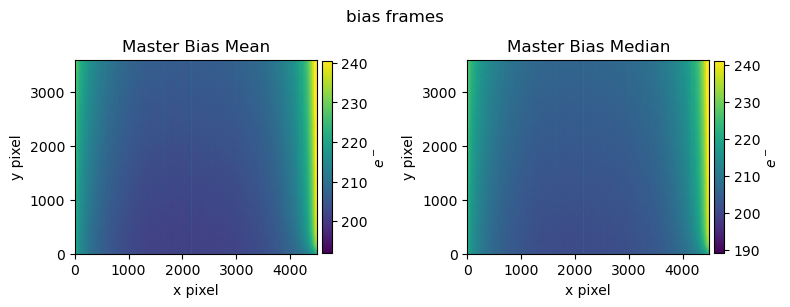

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(8,3))
fig.suptitle("bias frames")

im1 = ax[0].imshow(master_bias_mean, clim=np.quantile(master_bias_mean, [0.001, 0.99]), cmap='viridis', origin='lower')
plt.colorbar(im1, ax = ax[0], location='right', fraction=0.0375, pad=0.02, label="$e^-$")     
ax[0].set(xlabel="x pixel",ylabel="y pixel",title="Master Bias Mean")

im2 = ax[1].imshow(master_bias_median, clim=np.quantile(master_bias_median, [0.001, 0.99]), cmap='viridis', origin='lower')
plt.colorbar(im2, ax = ax[1], location='right', fraction=0.0375, pad=0.02, label="$e^-$")     
ax[1].set(xlabel="x pixel",ylabel="y pixel",title="Master Bias Median")

#plt.subplots_adjust(bottom=0.15) 
plt.tight_layout()
plt.show()


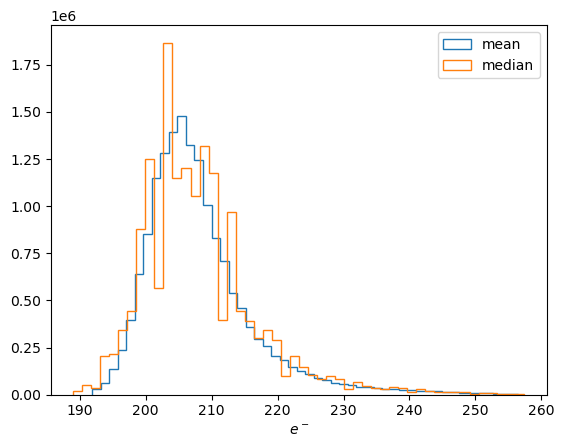

In [5]:
flat_mean = master_bias_mean.flatten()
flat_median = master_bias_median.flatten()

flat_mean = flat_mean[(flat_mean >= np.quantile(flat_mean, 0.001)) & (flat_mean <= np.quantile(flat_mean, 0.999))]
flat_median = flat_median[(flat_median >= np.quantile(flat_median, 0.001)) & (flat_median <= np.quantile(flat_median, 0.999))]

plt.hist(flat_mean,bins=50,histtype='step',label='mean')
plt.hist(flat_median,bins=50,histtype='step',label='median')
plt.xlabel('$e^-$')
plt.legend()
plt.show()

In [8]:
# Save the master bias as a new FITS file
hdu = fits.PrimaryHDU(master_bias_median)
hdu.writeto('data/master_bias.fit', overwrite=True)

In [4]:
from astropy.io import fits
import numpy as np
import os
input_dir = "data/dark_30_10_2024"

dark = []
exposure_time = []

for file_name in os.listdir(input_dir):

    file_path = os.path.join(input_dir, file_name)
    with fits.open(file_path) as hdul:
        exposure_time.append(hdul[0].header['EXPTIME'])
        dark.append(hdul[0].data)
        

In [5]:
print(exposure_time)

[1200.0, 1200.0, 1200.0, 900.0, 1200.0, 900.0, 300.0, 300.0, 1200.0, 1200.0, 300.0, 300.0, 1200.0, 300.0, 1200.0, 1200.0, 300.0, 300.0, 900.0, 1200.0]


In [6]:
# Stack frames and take medians

dark = np.array(dark) 
exposure_time = np.array(exposure_time)

dark_300_stack = np.stack(dark[exposure_time == 300])
dark_900_stack = np.stack(dark[exposure_time == 900])
dark_1200_stack = np.stack(dark[exposure_time == 1200])
del dark

dark_300_median = np.median(dark_300_stack, axis=0)

del dark_300_stack

dark_900_median = np.median(dark_900_stack, axis=0)

del dark_900_stack

dark_1200_median = np.median(dark_1200_stack, axis=0)

del dark_1200_stack



In [7]:
 # convert from ADU in electrons. 1 ADU = 0.6 e

gain_factor = 0.6

dark_300_median = dark_300_median * gain_factor
dark_900_median = dark_900_median * gain_factor
dark_1200_median = dark_1200_median * gain_factor


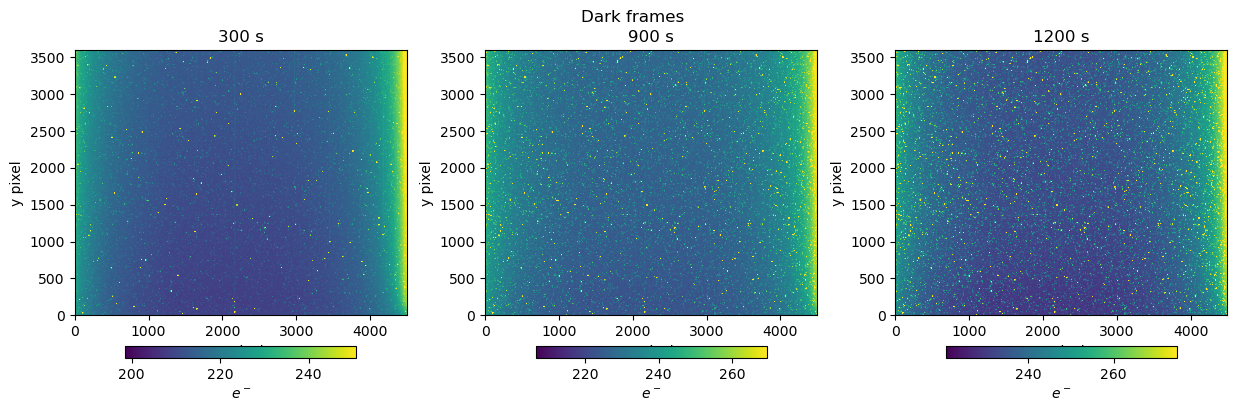

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(15,4))
fig.suptitle("Dark frames")

im0 = ax[0].imshow(dark_300_median, clim=np.quantile(dark_300_median, [0.01, 0.99]), cmap='viridis', origin='lower')  
plt.colorbar(im0, ax=ax[0], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  
ax[0].set_title("300 s")

im1 = ax[1].imshow(dark_900_median, clim=np.quantile(dark_900_median, [0.01, 0.99]), cmap='viridis', origin='lower')  
plt.colorbar(im1, ax=ax[1], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  
ax[1].set_title("900 s")

im2 = ax[2].imshow(dark_1200_median, clim=np.quantile(dark_1200_median, [0.01, 0.99]), cmap='viridis', origin='lower')  
plt.colorbar(im2, ax=ax[2], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  
ax[2].set_title("1200 s")

for i in range(3):
    ax[i].set(xlabel="x pixel",ylabel="y pixel")

plt.show()


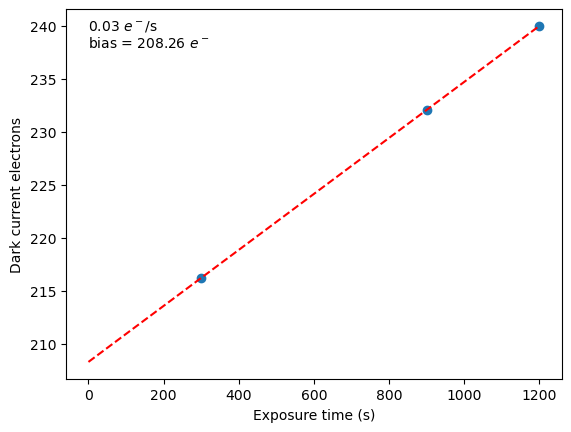

In [19]:
# Does dark current raise linearly ?

exp_times = [300,900,1200]
dark_mean_values = [np.mean(dark_300_median),np.mean(dark_900_median),np.mean(dark_1200_median)]

from scipy.optimize import curve_fit

dark_fit = curve_fit(lambda x, a, b: a*x + b, exp_times, dark_mean_values)

a,b = dark_fit[0][0], dark_fit[0][1]

plt.scatter(exp_times,dark_mean_values)

t = np.linspace(0,1200,100)
plt.plot(t, a*t + b, linestyle='--', color='red')

plt.xlabel('Exposure time (s)')
plt.ylabel('Dark current electrons')

plt.text(0,238,f"{a:.2f} $e^-$/s\nbias = {b:.2f} $e^-$")

plt.show()

In [22]:
# Save the master darks as a new FITS file

hdu = fits.PrimaryHDU(dark_300_median)
hdu.writeto('data/master_dark_300.fit', overwrite=True)

hdu = fits.PrimaryHDU(dark_900_median)
hdu.writeto('data/master_dark_900.fit', overwrite=True)

hdu = fits.PrimaryHDU(dark_1200_median)
hdu.writeto('data/master_dark_1200.fit', overwrite=True)
